In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anthem-lyric/kh-79.txt
/kaggle/input/anthem-lyric/bpt.txt
/kaggle/input/anthem-lyric/fr-15.txt
/kaggle/input/anthem-lyric/Congo.txt
/kaggle/input/anthem-lyric/bg5E44.txt
/kaggle/input/anthem-lyric/kh-75.txt
/kaggle/input/anthem-lyric/cu.txt
/kaggle/input/anthem-lyric/fr-30.txt
/kaggle/input/anthem-lyric/fj.txt
/kaggle/input/anthem-lyric/che-04.txt
/kaggle/input/anthem-lyric/Canada.txt
/kaggle/input/anthem-lyric/ic.txt
/kaggle/input/anthem-lyric/Botswana.txt
/kaggle/input/anthem-lyric/Central_African_Republic.txt
/kaggle/input/anthem-lyric/script.py
/kaggle/input/anthem-lyric/cr.txt
/kaggle/input/anthem-lyric/Colombia.txt
/kaggle/input/anthem-lyric/fr-52.txt
/kaggle/input/anthem-lyric/Albania.txt
/kaggle/input/anthem-lyric/ga.txt
/kaggle/input/anthem-lyric/csk.txt
/kaggle/input/anthem-lyric/Brazil.txt
/kaggle/input/anthem-lyric/bnr.txt
/kaggle/input/anthem-lyric/Argentina.txt
/kaggle/input/anthem-lyric/af-tal.txt
/kaggle/input/anthem-lyric/art.txt
/kaggle/input/anthem-lyri

In [9]:
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00


In [17]:
import cairosvg
import cv2
import numpy as np
import os

def convert_svg_to_png(svg_path, png_path):
    """Convert an SVG file to PNG."""
    try:
        cairosvg.svg2png(url=svg_path, write_to=png_path)
    except Exception as e:
        print(f"Error converting {svg_path}: {e}")

def extract_flag_features(image_path):
    """Extract color histogram features from a flag image."""
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not read image {image_path}")
        return np.zeros(512)  # Return a zero array

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    
    return hist

FLAGS_FOLDER = "/kaggle/input/flags-there"
PNG_FOLDER = "/kaggle/working/images"
os.makedirs(PNG_FOLDER, exist_ok=True)

# Convert all SVGs to PNG
for svg_file in os.listdir(FLAGS_FOLDER):
    if svg_file.endswith(".svg"):
        country = svg_file.replace(".svg", "")
        png_path = os.path.join(PNG_FOLDER, f"{country}.png")
        
        convert_svg_to_png(os.path.join(FLAGS_FOLDER, svg_file), png_path)

        # Now extract features from the PNG file
        features = extract_flag_features(png_path)


Error converting /kaggle/input/flags-there/Guam.svg: cairo returned CAIRO_STATUS_INVALID_SIZE: b'invalid value (typically too big) for the size of the input (surface, pattern, etc.)'
Error: Could not read image /kaggle/working/images/Guam.png


In [11]:
import cv2
import numpy as np
import librosa
import librosa.display
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import os

In [18]:
data = []

# Folder Paths
FLAGS_FOLDER = "/kaggle/working/images"  
ANTHEMS_FOLDER = "/kaggle/input/anthem-lyric" 
AUDIO_FOLDER = "/kaggle/input/anthem-audios" 

In [19]:
stop_words = set(["the", "and", "of", "to", "in", "for", "on", "with", "by", "as", "at", "an"])  # Add more as needed

# Function to extract color features from flag
def extract_flag_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100))
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [20]:
# Function to extract sentiment from anthem lyrics
def extract_text_features(text_path):
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read().lower()
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    sentiment = TextBlob(text).sentiment.polarity
    return len(words), sentiment  # Word count, sentiment score

# Function to extract audio features from anthem music
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    return tempo, spectral_centroid

In [21]:
for flag_file in os.listdir(FLAGS_FOLDER):
    country = flag_file.replace(".png", "")  # Extract country name
    flag_features = extract_flag_features(os.path.join(FLAGS_FOLDER, flag_file))
    
    anthem_file = os.path.join(ANTHEMS_FOLDER, f"{country}.txt")
    text_features = extract_text_features(anthem_file) if os.path.exists(anthem_file) else (0, 0)
    
    audio_file = os.path.join(AUDIO_FOLDER, f"{country}.mp3")
    audio_features = extract_audio_features(audio_file) if os.path.exists(audio_file) else (0, 0)
    
    data.append([country] + list(flag_features) + list(text_features) + list(audio_features))


In [22]:

# Convert to DataFrame
columns = ["Country"] + [f"Flag_{i}" for i in range(512)] + ["WordCount", "Sentiment", "Tempo", "SpectralCentroid"]
df = pd.DataFrame(data, columns=columns)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.iloc[:, 1:])
df_scaled = pd.DataFrame(scaled_data, columns=columns[1:])

# Compute Correlation Matrix
corr_matrix = df_scaled.corr()

## Checking correlation

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


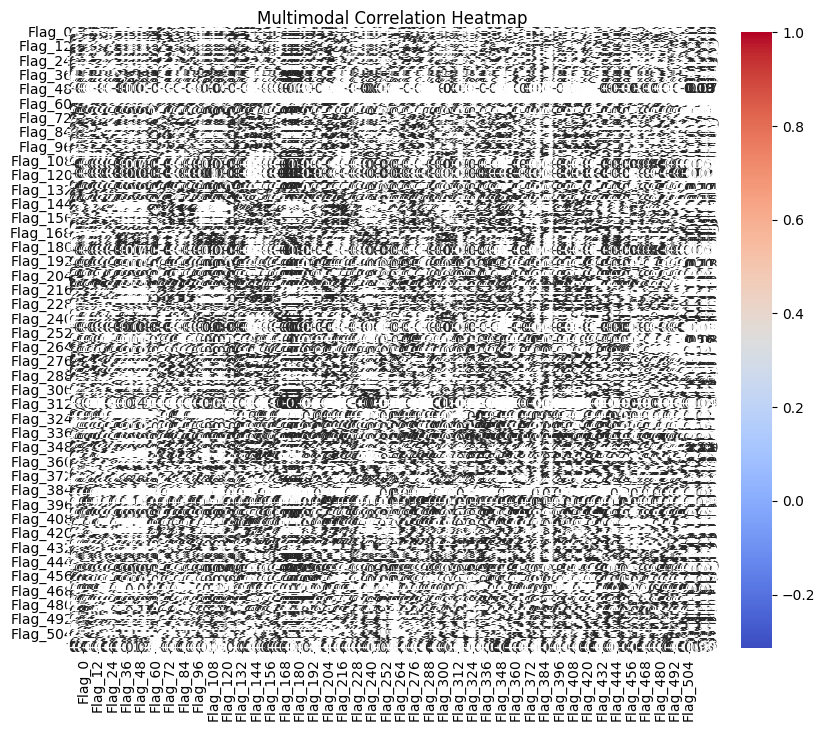

In [23]:


# Heatmap of Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Multimodal Correlation Heatmap")
plt.show()


In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

FLAGS_FOLDER = "/kaggle/working/images"

def plot_color_histogram(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read {image_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colors = ('r', 'g', 'b')  
    plt.figure(figsize=(6, 4))

    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)

    plt.title(f"Color Distribution: {os.path.basename(image_path)}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()




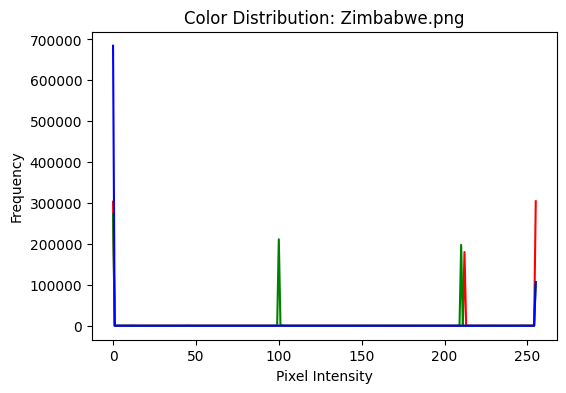

In [31]:
# Test with a flag
plot_color_histogram(os.path.join(FLAGS_FOLDER, "/kaggle/working/Zimbabwe.png"))

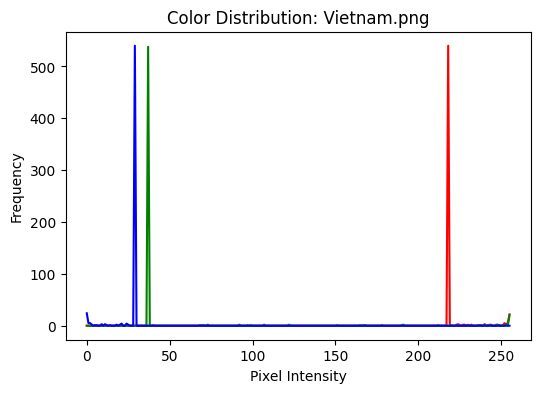

In [32]:
# Test with a flag
plot_color_histogram(os.path.join(FLAGS_FOLDER, "/kaggle/working/Vietnam.png"))